In [66]:
import pandas as pd
from matplotlib import pyplot as plt, ticker
plt.style.use("minimal")

FIGURE_SIZE = (5, 3.5)
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [67]:
def load_data():
    global results
    results = pd.read_csv("results.csv")
    results["response_time"] *= 1000

load_data()
results.sample(5)

,timestamp,trial,response_time,cursor_position,target_response,response
1758,2024-02-17 15:33:42.221608,6,302.2984,156,r,u
1343,2024-02-17 15:32:23.109432,5,119.7395,15,space,r
1532,2024-02-17 15:32:57.956314,5,27.7656,172,r,r
3643,2024-02-17 16:00:37.714736,1,79.9953,165,h,h
491,2024-02-17 15:29:34.081595,1,234.9167,185,a,a


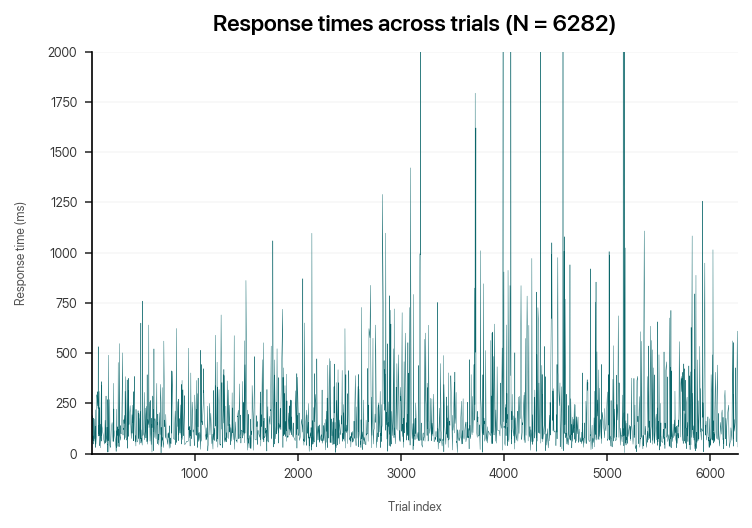

In [68]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
subset = results.sample(2000).sort_index()
plt.plot(
    subset.index, 
    subset["response_time"],
    linewidth = 0.2,
)
plt.title(f"Response times across trials (N = {len(results)})")
plt.xlabel("Trial index")
plt.ylabel("Response time (ms)")
plt.ylim((0, 2000))
plt.tight_layout()

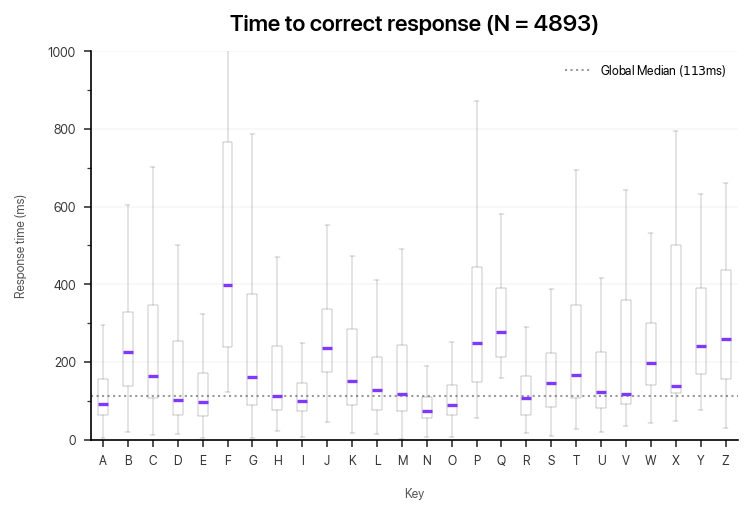

In [69]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
correctly_typed = results[(results["response"].isin(list(ALPHABET.lower()))) & (results["response"] == results["target_response"])]

for key, data in correctly_typed.groupby("response"):
    outlines_alpha = 0.5
    plt.boxplot(
        data["response_time"], 
        positions=[ord(key)],
        widths = 0.4,
        boxprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        whiskerprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        capprops = dict(linewidth = 0.2, alpha = outlines_alpha),
        flierprops = dict(marker = "o", markersize = 1, alpha = outlines_alpha, markeredgecolor = "none"),
        medianprops = dict(linewidth = 1.6, color = "C2"),
    )
plt.axhline(
    y = correctly_typed["response_time"].median(),
    linestyle = ":",
    linewidth = 1,
    color = "black",
    alpha = 0.4,
    zorder = -1,
    label = f"""Global Median (${correctly_typed["response_time"].median():.0f}$ms)"""
)
plt.legend(loc = "upper right")
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(correctly_typed)})")
plt.xlabel("Key")
plt.ylabel("Response time (ms)")
plt.xticks(range(97, 97 + 26), ALPHABET)
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.tight_layout()

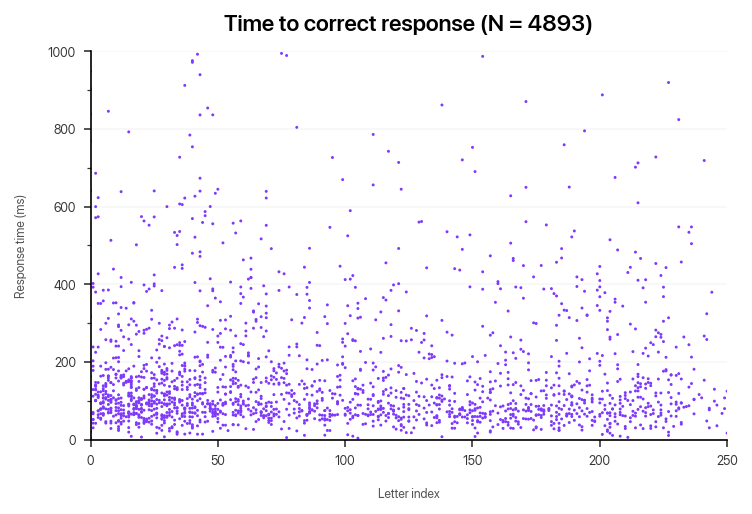

In [70]:
load_data()
plt.figure(figsize=FIGURE_SIZE)
plt.scatter(
    subset["cursor_position"], 
    subset["response_time"],
    marker = "o",
    s = 2,
    color = "C2",
    edgecolor = "none",
)
plt.suptitle("")
plt.title(f"Time to correct response (N = {len(correctly_typed)})")
plt.xlabel("Letter index")
plt.ylabel("Response time (ms)")
plt.yticks(range(0, 1000, 100))
plt.ylim((0, 1000))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(100))
plt.tight_layout()